## Importing libraries

In [1]:
# Import libraries 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import preprocessing


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import tree


## Loading The dataset

In [2]:
#reading the dataset file using pandas
Data = pd.read_csv('Clean_Dataset.csv')

## About the Dataset

In [3]:
# give 1st 5 row command name attribute and variables

Data.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [4]:

# give last 5 rows of the dataset
Data.tail()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
300148,300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585
300152,300152,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,81585


In [5]:


#shows number of rows and columns in the dataset
Data.shape

(300153, 12)

In [6]:

# Generate descriptive statistics
Data.describe()

,Unnamed: 0,duration,days_left,price
count,300153.000000,300153.000000,300153.000000,300153.000000
mean,150076.000000,12.221021,26.004751,20889.660523
std,86646.852011,7.191997,13.561004,22697.767366
min,0.000000,0.830000,1.000000,1105.000000
25%,75038.000000,6.830000,15.000000,4783.000000
50%,150076.000000,11.250000,26.000000,7425.000000
75%,225114.000000,16.170000,38.000000,42521.000000
max,300152.000000,49.830000,49.000000,123071.000000


In [7]:

#information about dataset
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


## Dealing with missing data

In [8]:
# Checking and counting for missing data points for each column
Data.isnull().sum()

Unnamed: 0          0
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

In [9]:
# Function to detect outliers using the IQR method
def detect_outliers_iqr(data, column_name):
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = data[(data[column_name] < lower_bound) | (data[column_name] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Detect outliers in numeric columns
numeric_columns = ['duration', 'days_left', 'price']
outliers_info = {}

for column in numeric_columns:
    outliers, lower, upper = detect_outliers_iqr(Data, column)
    outliers_info[column] = {
        'outliers_count': len(outliers),
        'lower_bound': lower,
        'upper_bound': upper
    }

outliers_info


{'duration': {'outliers_count': 2110,
  'lower_bound': -7.1800000000000015,
  'upper_bound': 30.180000000000003},
 'days_left': {'outliers_count': 0, 'lower_bound': -19.5, 'upper_bound': 72.5},
 'price': {'outliers_count': 123,
  'lower_bound': -51824.0,
  'upper_bound': 99128.0}}

In [10]:
# Function to cap outliers within the IQR bounds
def cap_outliers(data, column_name, lower_bound, upper_bound):
    data[column_name] = data[column_name].clip(lower=lower_bound, upper=upper_bound)
    return data

# Define the bounds for each column based on the result
outlier_bounds = {
    'duration': {'lower_bound': -7.18, 'upper_bound': 30.18},
    'days_left': {'lower_bound': -19.5, 'upper_bound': 72.5},
    'price': {'lower_bound': -51824.0, 'upper_bound': 99128.0}
}

# Apply capping to each column with detected outliers
for column, bounds in outlier_bounds.items():
    Data = cap_outliers(Data, column, bounds['lower_bound'], bounds['upper_bound'])

# Verify if outliers are removed
updated_outliers_info = {}

for column in outlier_bounds.keys():
    outliers, _, _ = detect_outliers_iqr(Data, column)
    updated_outliers_info[column] = {'outliers_count': len(outliers)}

# Print updated results
print("Updated Outlier Counts After Capping:", updated_outliers_info)


Updated Outlier Counts After Capping: {'duration': {'outliers_count': 0}, 'days_left': {'outliers_count': 0}, 'price': {'outliers_count': 0}}


### Inference - data do not contain any Null Values

In [11]:
Data['source_city'].value_counts() 
 # returns object containing counts of unique values

source_city
Delhi        61343
Mumbai       60896
Bangalore    52061
Kolkata      46347
Hyderabad    40806
Chennai      38700
Name: count, dtype: int64

In [12]:
Data['airline'].value_counts() 
 # returns object containing counts of unique values

airline
Vistara      127859
Air_India     80892
Indigo        43120
GO_FIRST      23173
AirAsia       16098
SpiceJet       9011
Name: count, dtype: int64

In [13]:
Data['departure_time'].value_counts() 
 # returns object containing counts of unique values

departure_time
Morning          71146
Early_Morning    66790
Evening          65102
Night            48015
Afternoon        47794
Late_Night        1306
Name: count, dtype: int64

In [14]:
Data['destination_city'].value_counts() 
 # returns object containing counts of unique values

destination_city
Mumbai       59097
Delhi        57360
Bangalore    51068
Kolkata      49534
Hyderabad    42726
Chennai      40368
Name: count, dtype: int64

In [15]:
Data['duration'].value_counts() 
 # returns object containing counts of unique values

duration
2.17     4242
2.25     4036
2.75     2879
2.08     2755
2.83     2323
         ... 
29.25      15
6.98       15
13.40      15
29.92      11
6.07        5
Name: count, Length: 357, dtype: int64

In [16]:
#find columns name air quality is working as data frame
Data.columns


Index(['Unnamed: 0', 'airline', 'flight', 'source_city', 'departure_time',
       'stops', 'arrival_time', 'destination_city', 'class', 'duration',
       'days_left', 'price'],
      dtype='object')

## Data Preprocessing


In [17]:
#datatype of each attribute
Data.dtypes


Unnamed: 0            int64
airline              object
flight               object
source_city          object
departure_time       object
stops                object
arrival_time         object
destination_city     object
class                object
duration            float64
days_left             int64
price                 int64
dtype: object

## Data Visualization

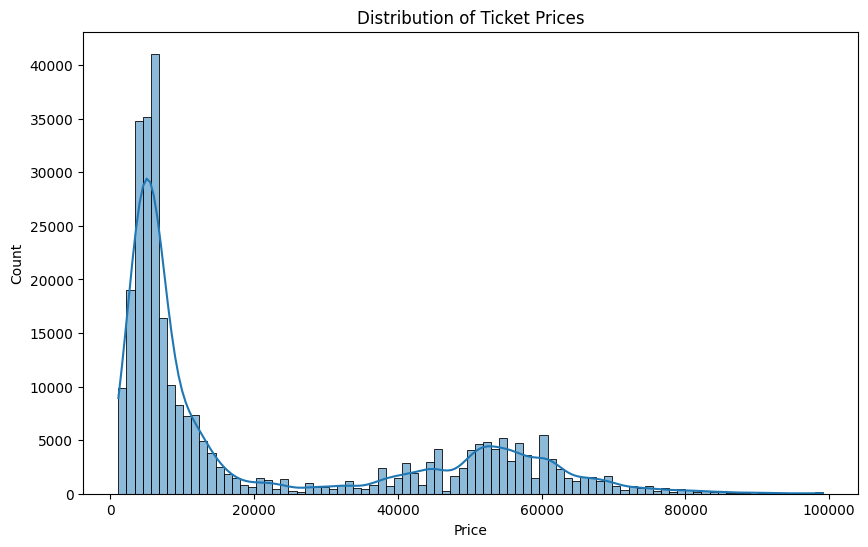

In [18]:
#Histogram representing distribution of ticket prices
plt.figure(figsize=(10, 6))
sns.histplot(data=Data, x='price', kde=True)
plt.title('Distribution of Ticket Prices')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

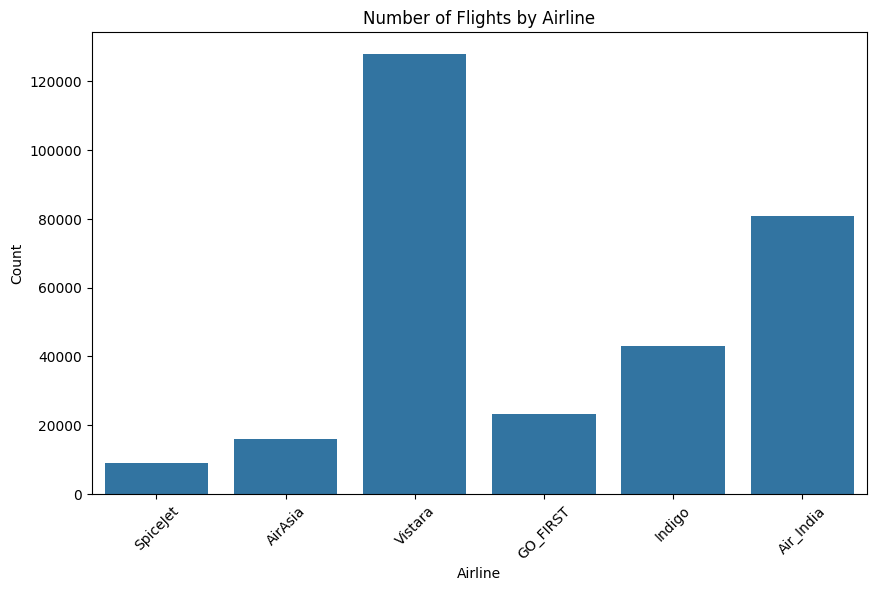

In [19]:
#Bar chart of number of flights by airlines
plt.figure(figsize=(10, 6))
sns.countplot(data=Data, x='airline')
plt.title('Number of Flights by Airline')
plt.xlabel('Airline')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Text(0.5, 1.0, '')

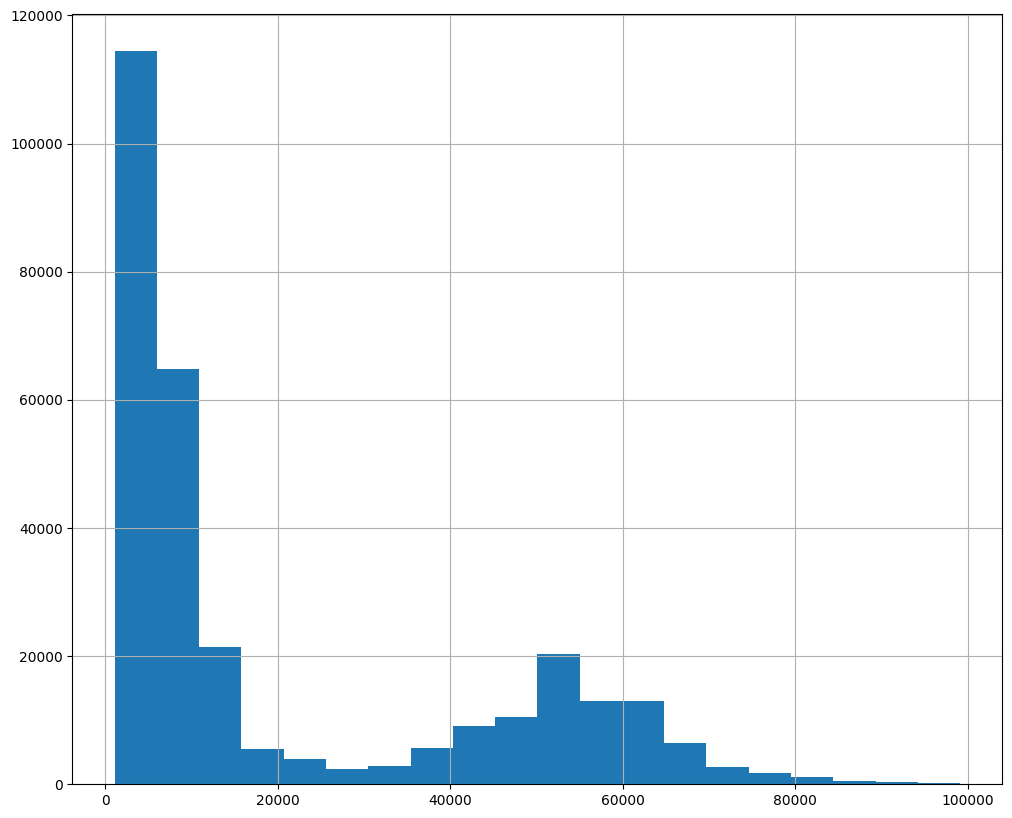

In [20]:
#Prices distribution
plt.figure(figsize=(12,10))
Data['price'].hist(bins=20)
plt.title('')

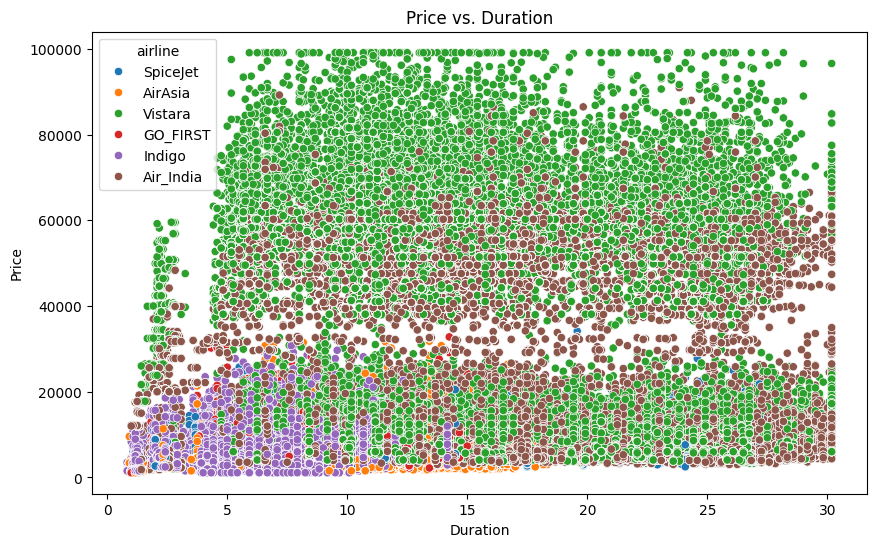

In [21]:
# Scatter plot of price versus duration
plt.figure(figsize=(10, 6))
sns.scatterplot(data=Data, x='duration', y='price', hue='airline')
plt.title('Price vs. Duration')
plt.xlabel('Duration')
plt.ylabel('Price')
plt.show()

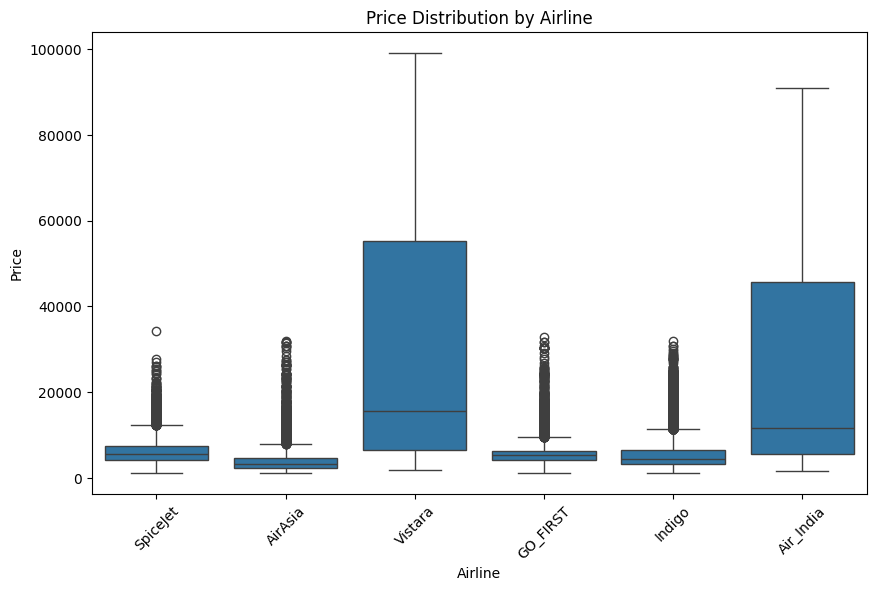

In [22]:
#Box plot of price by airline
plt.figure(figsize=(10, 6))
sns.boxplot(data=Data, x='airline', y='price')
plt.title('Price Distribution by Airline')
plt.xlabel('Airline')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

In [23]:
#FUNCTION FOR PLOTTING - 
def price_and(x):
    z = Data.groupby(x)['price'].sum().reset_index()
    plt.figure(figsize=(10,5))
    sns.barplot(data = z, x= x,y='price')
    plt.ticklabel_format(style='plain', axis='y')
    plt.show()

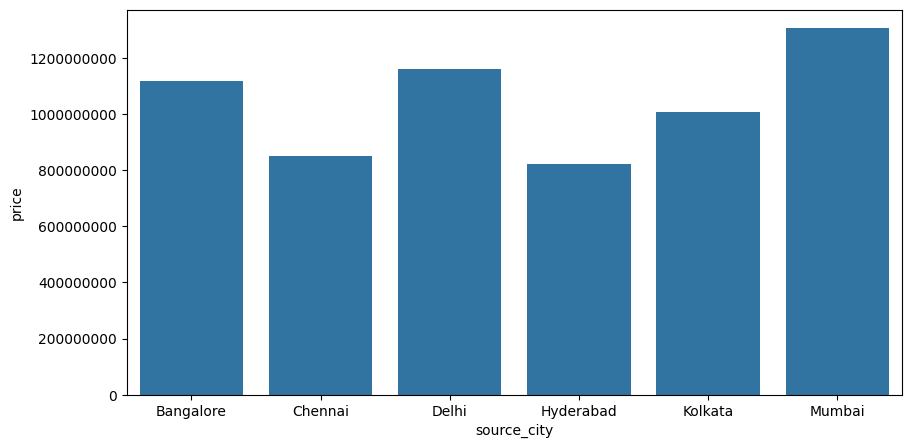

In [24]:
price_and('source_city')

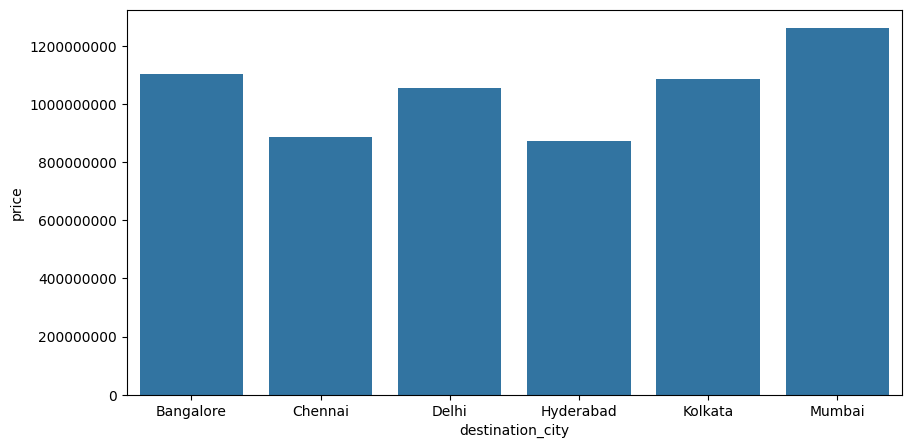

In [25]:
price_and('destination_city')

Departure city counts from more to less:
 source_city
Delhi        61343
Mumbai       60896
Bangalore    52061
Kolkata      46347
Hyderabad    40806
Chennai      38700
Name: count, dtype: int64


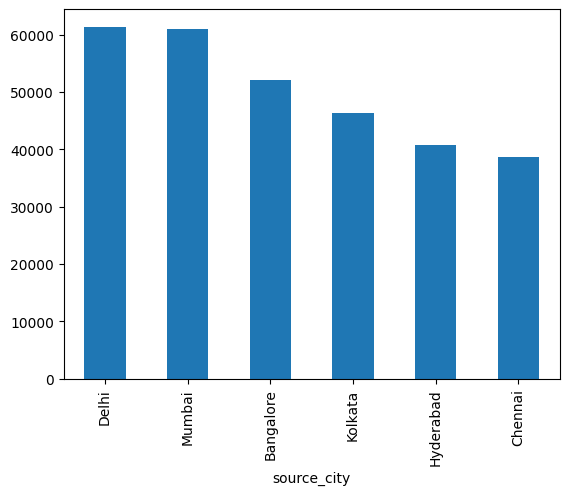

In [26]:

# Count the occurrences of source cities
source_city_counts = Data['source_city'].value_counts()
print("Departure city counts from more to less:\n", source_city_counts)
source_city_counts.plot(kind='bar');

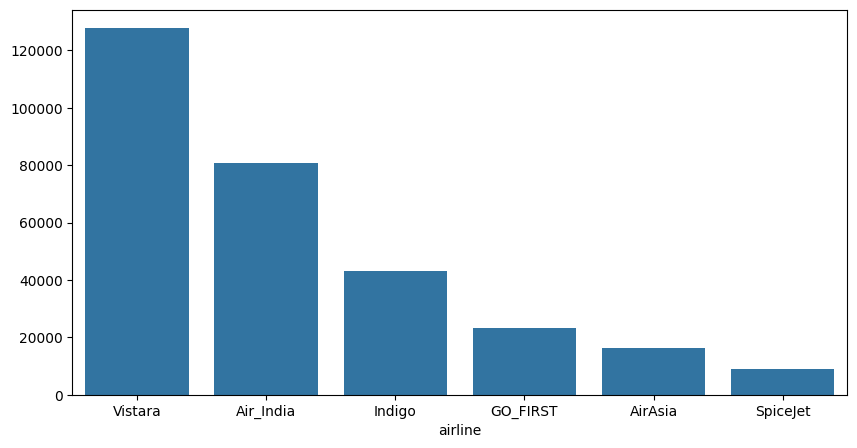

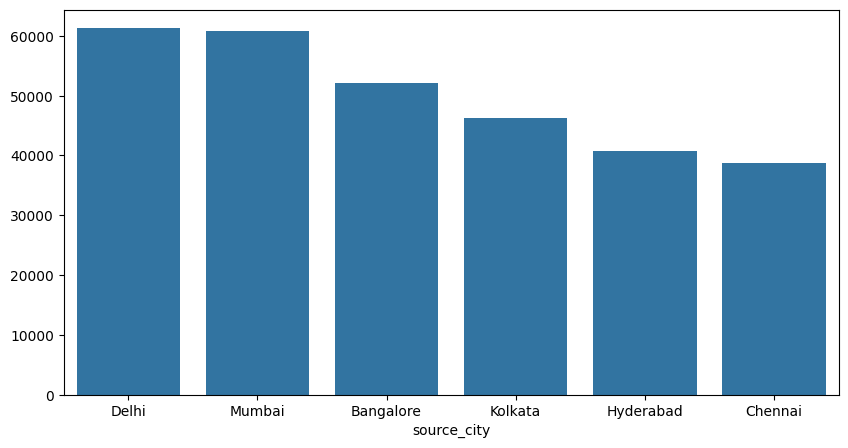

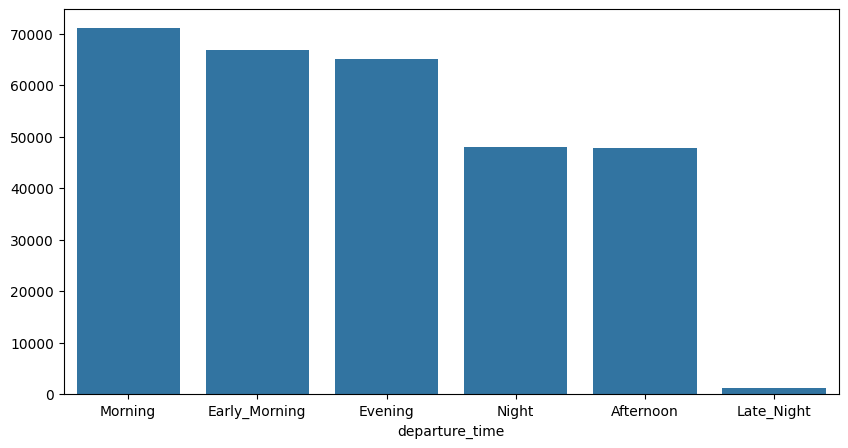

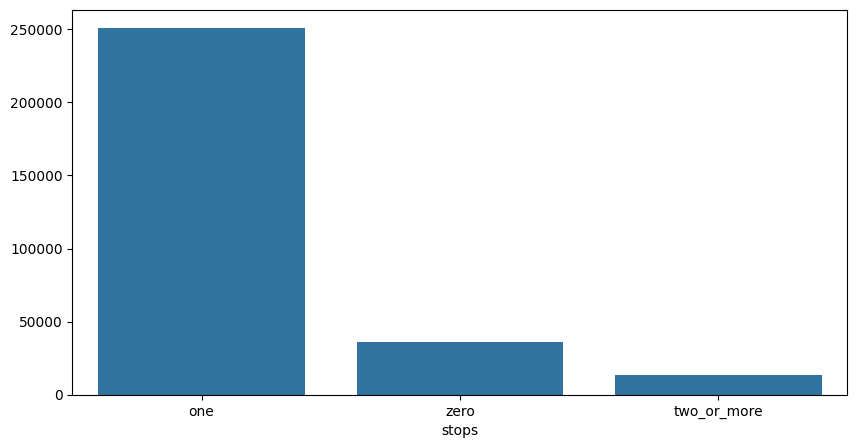

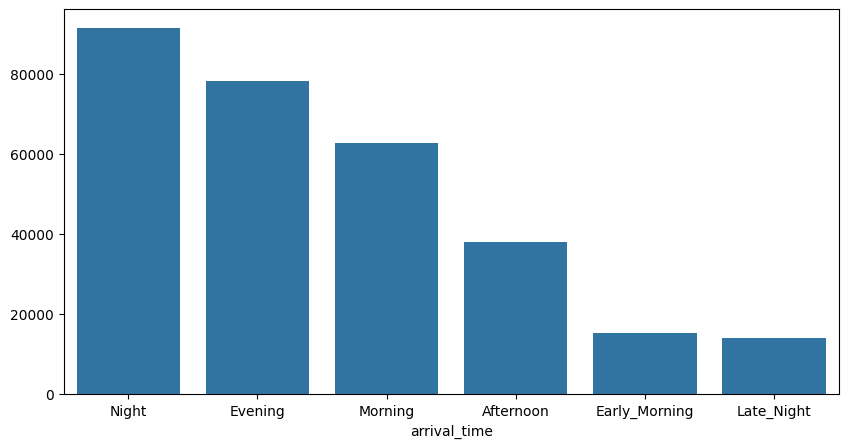

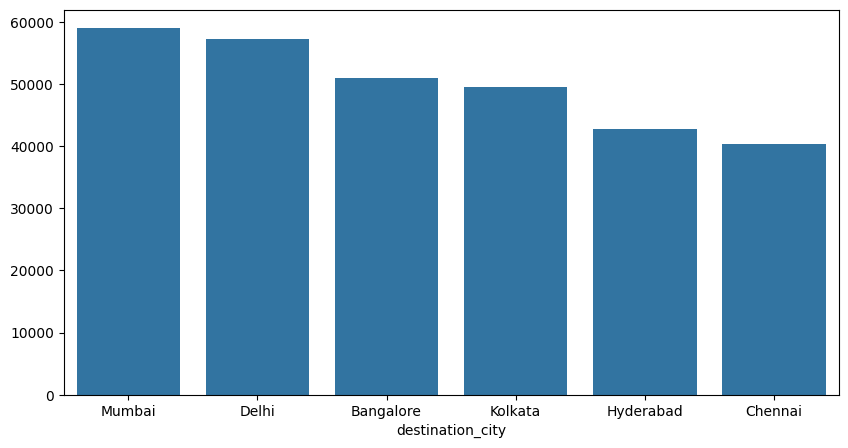

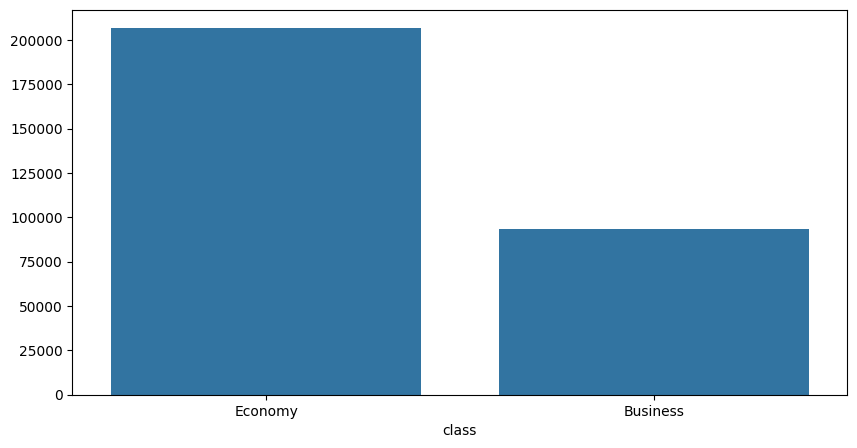

In [27]:
cat = ['airline','source_city', 'departure_time', 'stops','arrival_time', 'destination_city', 'class']

#VISUALIZING THE VALUE COUNTS
for i in cat:
    count_data = Data[i].value_counts()
    plt.figure(figsize=(10, 5))
    sns.barplot(x=count_data.index, y=count_data.values)
    plt.show()

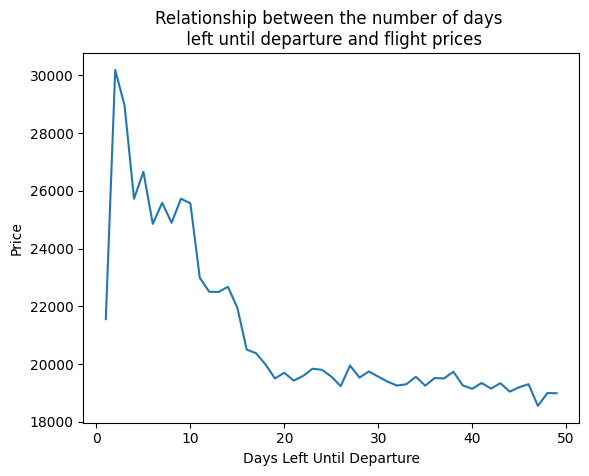

In [28]:
# Create a plot of days_left vs. price
Data.groupby('days_left')['price'].mean().plot()
plt.xlabel('Days Left Until Departure')
plt.ylabel('Price')
plt.title('Relationship between the number of days \n left until departure and flight prices')
plt.show()

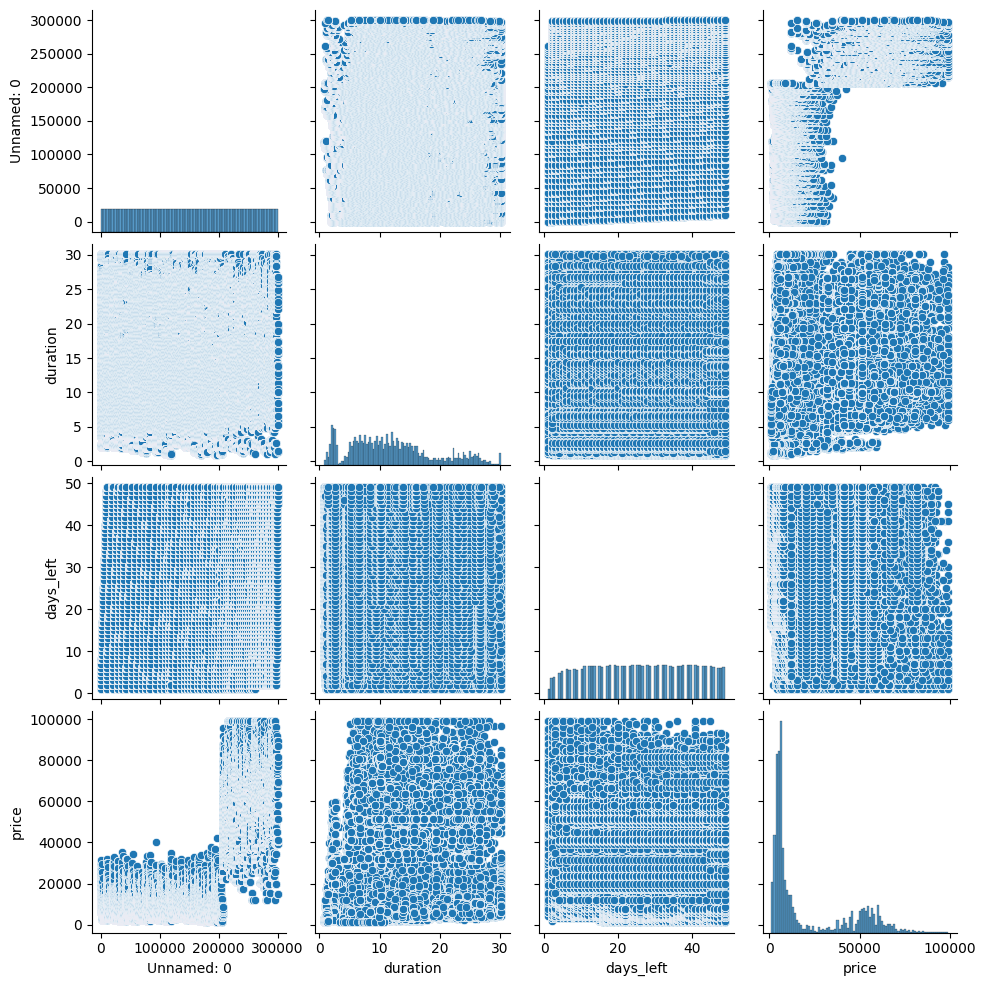

In [29]:
sns.pairplot(Data);

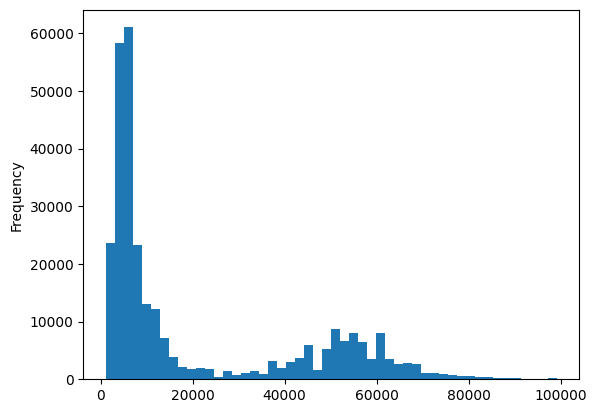

In [30]:
Data["price"].plot.hist(bins=50);

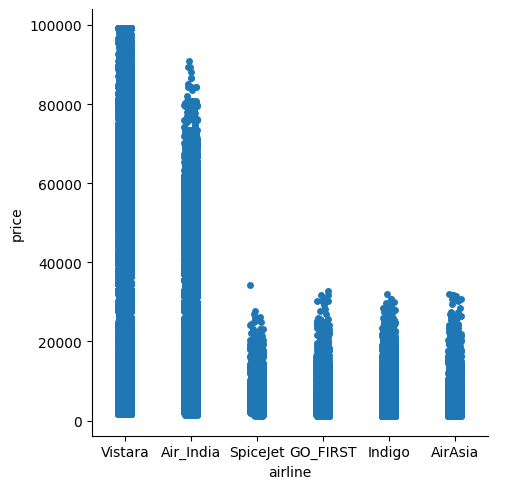

In [31]:
sns.catplot(y='price', x='airline', data=Data.sort_values('price', ascending=False, kind='quick'))
plt.show()

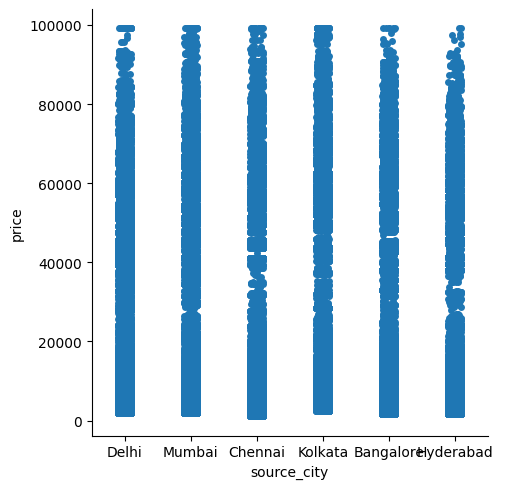

In [32]:
sns.catplot(y='price', x='source_city', data=Data.sort_values('price', ascending=False, kind='quick'))
plt.show()

## Data Analysis

In [33]:
# Calculate the average flight duration by class
duration_by_class = Data.groupby('class')['duration'].mean()
print("Average Flight Duration by Class:\n", duration_by_class)

Average Flight Duration by Class:
 class
Business    13.699485
Economy     11.521625
Name: duration, dtype: float64


In [34]:
# Calculate the average price by number of stops
price_by_stops = Data.groupby('stops')['price'].mean()
print("Change in average prices as per the number of stops:\n", price_by_stops)

Change in average prices as per the number of stops:
 stops
one            22898.940366
two_or_more    14101.177028
zero            9375.938535
Name: price, dtype: float64


In [35]:
Data.groupby(['class','airline'])['price'].max()

class     airline  
Business  Air_India    90970
          Vistara      99128
Economy   AirAsia      31917
          Air_India    42349
          GO_FIRST     32803
          Indigo       31952
          SpiceJet     34158
          Vistara      37646
Name: price, dtype: int64

In [36]:
Data.duration.max()

30.18

##  Handling the Categorical data

1. Nominal Data: Data are not in any order. OneHotEncoder is used.
2. Ordinal Data: Data is in order. LabelEncoder is used in this case

In [37]:
Data['airline'].value_counts()

airline
Vistara      127859
Air_India     80892
Indigo        43120
GO_FIRST      23173
AirAsia       16098
SpiceJet       9011
Name: count, dtype: int64

In [38]:
cat = ['airline','source_city','departure_time','arrival_time','destination_city','class']
feat = ['airline','source_city','departure_time','stops','arrival_time','destination_city','class','duration','days_left']
target = ['price']

In [39]:
import numpy as np
mapping = {'one': 1, 'zero': 0, 'two_or_more': 2}
replace_func = np.vectorize(lambda x: mapping.get(x, -1))

Data['stops'] = replace_func(Data['stops'])
Data['stops']

0         0
1         0
2         0
3         0
4         0
         ..
300148    1
300149    1
300150    1
300151    1
300152    1
Name: stops, Length: 300153, dtype: int32

In [40]:
le = preprocessing.LabelEncoder()

for i in cat:
    Data[i] = le.fit_transform(Data[i])

## Feature Selection

In [41]:

#FEATURE SELECTION
Data = Data.drop('flight', axis=1)
Data = Data.drop('Unnamed: 0', axis=1)


In [42]:
X = Data[feat] #feature selection
y = Data['price']        #target column

## Saving Cleaned Data

In [43]:
Data.to_csv('Indian_Airlines_cleaned_data.csv',index=False)

Data= pd.read_csv('Indian_Airlines_cleaned_data.csv')
Data

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,4,2,2,0,5,5,1,2.17,1,5953
1,4,2,1,0,4,5,1,2.33,1,5953
2,0,2,1,0,1,5,1,2.17,1,5956
3,5,2,4,0,0,5,1,2.25,1,5955
4,5,2,4,0,4,5,1,2.33,1,5955
...,...,...,...,...,...,...,...,...,...,...
300148,5,1,4,1,2,3,0,10.08,49,69265
300149,5,1,0,1,5,3,0,10.42,49,77105
300150,5,1,1,1,5,3,0,13.83,49,79099
300151,5,1,1,1,2,3,0,10.00,49,81585


## Split the dataset into Training and Testing

In [44]:

# Split training set into training and validation sets (60/40 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Split at 60/20/20

In [45]:
X_train.shape , X_test.shape

((240122, 9), (60031, 9))

In [46]:
y_train.shape, y_test.shape

((240122,), (60031,))

## Model Building Using Random Forest

In [47]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 150 ,max_depth = 30, min_samples_leaf = 5, min_samples_split = 30)
rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=30, min_samples_leaf=5, min_samples_split=30,
                      n_estimators=150)

In [48]:
y_pred = rf.predict(X_test) 

In [49]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


In [50]:
print(r2_score(y_pred,y_test))

0.9852754250662109


In [51]:
print(mean_absolute_error(y_pred,y_test))

1268.9621299263442


In [52]:
import pickle

In [53]:
# save the model
model = rf  # Your machine learning model object
file_path = 'rf-cyber.pkl'  # Path to the file where you want to save the model

with open(file_path, 'wb') as file:
    pickle.dump(model, file)

In [54]:
import pickle
# load the model

file_path = 'rf-cyber.pkl'  # Path to the saved model file

with open(file_path, 'rb') as file:
    loaded_model = pickle.load(file)

In [55]:
X_train.columns

Index(['airline', 'source_city', 'departure_time', 'stops', 'arrival_time',
       'destination_city', 'class', 'duration', 'days_left'],
      dtype='object')

In [64]:
loaded_model.predict([[3,2,0,1,2,5,1,6.0,4]])

array([9877.65571036])

In [65]:
loaded_model.predict([[5,2,2,1,5,5,1,4.42,4]])

array([9750.48308763])

In [67]:
loaded_model.predict([[4,2,2,0,5,5,1,2.17,1]])

array([7502.55081785])